2018 Oct 9<br>
I've gotten worried that my photometric model needs an overall baseline, that $F_{\rm 0}$ doesn't serve that purpose since the eclipse signal zeros out the planet's phase curve in the eclipse.<br>

If so, it might explain why my model fit parameters keep coming out so different from Faigler et al.'s.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import bindata, transit_duration
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import emcee
from emcee.autocorr import integrated_time

import dill

K76 = Kepler76_params()

In [2]:
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846897


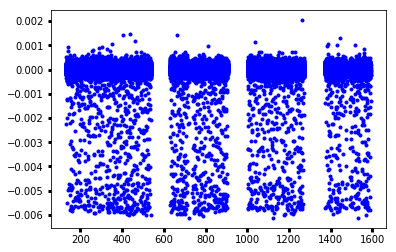

In [3]:
# Initial fit using Faigler's parameters (with my own T0)
plt.plot(filtered_time, filtered_flux, 'b.')

In [21]:
def fit_all_signals(cur_time, cur_p, cur_b, cur_T0, cur_Aellip, cur_Abeam,
        cur_F0, cur_eclipse_depth, cur_phase_shift):
    params = K76.saved_params.copy()

    params['p'] = cur_p
    params['b'] = cur_b
    params['T0'] = cur_T0
    params['Aellip'] = cur_Aellip
    params['Abeam'] = cur_Abeam
    params['F0'] = cur_F0
    params['Aplanet'] = cur_eclipse_depth - cur_F0
    params['phase_shift'] = cur_phase_shift

    cur_BC = BEER_curve(cur_time, params,
            supersample_factor=10, exp_time=30./60./24.)

    return cur_BC.all_signals()

In [23]:
bounds = ([-1000e-6, 0., -1, K76.T0*0.95, -500e-6, -500e-6, -500e-6, 0., -1],
          [1000e-6, 0.2, 1., K76.T0*1.05, 500e-6, 500e-6, 500e-6, 500e-6, 1])

ind = ~transit_indices(folded_time, K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])

time = folded_time
data = filtered_flux
err = unbinned_noise*np.ones_like(folded_time)

initial_guess = [0., K76.saved_params['p'], K76.saved_params['b'], K76.saved_params['T0'],
                 K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['F0'], 
                 K76.saved_params['F0'] + K76.saved_params['Aplanet'], K76.saved_params['phase_shift']]
#popt, pcov = curve_fit(fit_all_signals, time, data, sigma=unbinned_noise*np.ones_like(time), p0=initial_guess, bounds=bounds)
print(popt[1:])
print(popt[6] - popt[5])
#print(np.sqrt(pcov.diagonal()))

binned_time, binned_flux, binned_err = bindata(time, data, 1./60./24.)

plt.plot(binned_time, binned_flux)
plt.plot(binned_time, fit_all_signals(binned_time, *popt), color='red')
#plt.ylim([-100e-6, 100e-6])

NameError: global name 'cur_F0' is not defined